In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from pylab import rcParams
import plotly.graph_objects as go
import missingno as msno
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import scipy
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, classification_report
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from pyod.models.ecod import ECOD

In [2]:
df = pd.read_csv('datasets/numerical_data.csv')

In [3]:
diseased_data = df[df['HeartDisease'] == 1]

# Feature Engineering

**Health Ratio (HealthRatio):**
We created a new feature called 'HealthRatio' by taking the ratio of 'PhysicalHealth' to 'MentalHealth'. This ratio is intended to capture the relative balance of physical to mental health days. To avoid division by zero, 'MentalHealth' values of zero were replaced with one.

**Lifestyle Score (LifestyleScore):**
This composite score was crafted to encapsulate lifestyle choices that could impact health. It included three components:

**Alcohol Drinking (AlcoholScore):** A score that inversely reflects alcohol consumption, where not drinking is considered positive and thus scored higher.

**Physical Activity (PhysicalActivityScore):** Directly included as being physically active contributes positively to the score.

**Sleep Time (SleepScore):** A normalized score that peaks at the recommended 7-9 hours of sleep, with a linear decrease toward 0 as the number of hours deviates from this range. This was calculated using a custom function designed to model a healthy sleep pattern.
Additionally, 'Smoking' was integrated into the 'LifestyleScore' with a scoring system that assigns the highest points to non-smokers, fewer points to former smokers, no points to approximate smokers, and negative points to current smokers.

**Adjusted Health Ratio (AdjustedHealthRatio):**
To include the general health status (GenHealth), which is a binary indicator of whether a person is generally healthy, we adjusted the 'HealthRatio'. We applied a factor that increases the 'HealthRatio' for individuals who are generally healthy and decreases it for those who are not.

In [4]:
# Avoid division by zero by replacing '0' with '1' in 'MentalHealth'
diseased_data['MentalHealth'].replace(0, 1, inplace=True)

# Calculate the initial HealthRatio
diseased_data['HealthRatio'] = diseased_data['PhysicalHealth'] / diseased_data['MentalHealth']

# Adjust the HealthRatio based on GenHealth
# Let's say we want to increase the ratio by 10% if generally healthy and decrease it by 10% if not
adjustment_factor = diseased_data['GenHealth'].apply(lambda x: 1.1 if x == 1 else 0.9)
diseased_data['AdjustedHealthRatio'] = diseased_data['HealthRatio'] * adjustment_factor

/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_34086/4092774513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diseased_data['MentalHealth'].replace(0, 1, inplace=True)
/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_34086/4092774513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diseased_data['HealthRatio'] = diseased_data['PhysicalHealth'] / diseased_data['MentalHealth']
/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_34086/4092774513.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [5]:
# Assuming that 0 in 'AlcoholDrinking' means not drinking and 1 means drinking
# And that 1 in 'PhysicalActivity' means active and 0 means inactive
# We will create a score such that:
# Not drinking alcohol: +1 point
# Being physically active: +1 point
# 7-9 hours of sleep: +1 point, scaling down to 0 as you move away from this range

# Invert the 'AlcoholDrinking' score so that '0' becomes a positive contribution
diseased_data['AlcoholScore'] = 1 - diseased_data['AlcoholDrinking']

# Keep 'PhysicalActivity' as it is (assuming '1' is active and already positive)
diseased_data['PhysicalActivityScore'] = diseased_data['PhysicalActivity']

# Create a normalized sleep score that peaks at 7-9 hours and decreases towards 0 or 24 hours
# The simplest way could be to use a Gaussian-like function or triangular function

# Using a triangular function for simplicity
def sleep_score(hours):
    if 7 <= hours <= 9:
        return 1  # Peak value
    elif hours < 7:
        return hours / 7  # Linearly decrease to 0 at 0 hours
    else:
        return max(0, (24 - hours) / (24 - 9))  # Linearly decrease to 0 at 24 hours

diseased_data['SleepScore'] = diseased_data['SleepTime'].apply(sleep_score)


/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_34086/4090659418.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diseased_data['AlcoholScore'] = 1 - diseased_data['AlcoholDrinking']
/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_34086/4090659418.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diseased_data['PhysicalActivityScore'] = diseased_data['PhysicalActivity']
/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_34086/4090659418.py:26: SettingWithCopyWarning: 
A v

Let's assume the following points system based on the possible health impact of each smoking status:

'Never': +1 point (most positive impact on health)

'Former Smoker': +0.5 points (positive impact due to quitting)

'Approximate Smoker': 0 points (neutral or unclear impact)

'Smoker': -1 points (negative impact on health)

In [6]:
# Define a scoring function for Smoking
def smoking_score(category):
    scores = {1: -1,  # Smoker
              2: 0,   # Approximate Smoker
              3: 0.5, # Former Smoker
              4: 1}   # Never
    return scores.get(category, 0)  # Default to 0 if category is not in the dictionary

# Apply the smoking score to the 'Smoking' column
diseased_data['SmokingScore'] = diseased_data['Smoking'].apply(smoking_score)

# Now add the 'SmokingScore' to the 'LifestyleScore' calculation
diseased_data['LifestyleScore'] = diseased_data[['AlcoholScore', 'PhysicalActivityScore', 'SleepScore', 'SmokingScore']].sum(axis=1)

/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_34086/1815668790.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diseased_data['SmokingScore'] = diseased_data['Smoking'].apply(smoking_score)
/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_34086/1815668790.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diseased_data['LifestyleScore'] = diseased_data[['AlcoholScore', 'PhysicalActivityScore', 'SleepScore', 'SmokingScore']].sum(axis=1)


In this code, we define a function smoking_score to assign points to each smoking category, apply this function to the 'Smoking' column to create a 'SmokingScore', and then include this 'SmokingScore' in the calculation of the 'LifestyleScore'.

Adjust the specific scores as you see fit based on your understanding of the health impacts of each smoking status. Remember, the key to creating a composite score like this is to ensure that each component is weighted appropriately to reflect its importance in the overall score.

In [7]:
diseased_data.head()

,HeartDisease,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,...,KidneyDisease,SkinCancer,BMI,HealthRatio,AdjustedHealthRatio,AlcoholScore,PhysicalActivityScore,SleepScore,SmokingScore,LifestyleScore
9,1.0,3.0,0.0,0.0,6.0,15.0,1.0,2,12.0,2.0,...,0.0,0.0,28.87,0.4,0.36,1.0,0.0,0.800000,0.5,2.300000
15,1.0,1.0,0.0,0.0,30.0,30.0,1.0,1,9.0,1.0,...,0.0,0.0,34.30,1.0,0.90,1.0,0.0,0.600000,-1.0,0.600000
43,1.0,3.0,0.0,1.0,10.0,10.0,1.0,1,12.0,1.0,...,0.0,1.0,32.98,1.0,0.90,1.0,1.0,0.571429,0.5,3.071429
51,1.0,0.0,0.0,0.0,30.0,2.0,1.0,2,13.0,1.0,...,0.0,1.0,25.06,15.0,13.50,1.0,0.0,1.000000,0.0,2.000000
52,1.0,3.0,0.0,0.0,6.0,2.0,1.0,2,12.0,1.0,...,1.0,0.0,30.23,3.0,2.70,1.0,1.0,1.000000,0.5,3.500000


# Clustering

**Rescaling for Clustering:**
Prior to clustering, we scaled the features using StandardScaler to ensure each feature contributed equally to the clustering process. This scaling was crucial as KMeans clustering is sensitive to the scale of the data.

**Cluster Analysis with KMeans:**
We applied KMeans clustering to the scaled features and determined the optimal number of clusters using the elbow method.

**Post-Clustering Operations:**
After clustering, we assigned cluster labels to the original data and then rescaled the features back to their original values using the inverse transformation provided by the StandardScaler. This rescaling was essential for interpretability of the results.
Each of these steps was taken to ensure that the data would reveal meaningful patterns when subjected to cluster analysis. The goal was to capture the nuances of health-related behaviors and conditions and to see how these nuances might cluster within the larger dataset.

In [8]:
features_data = diseased_data[['AgeCategory', 'AdjustedHealthRatio', 'LifestyleScore', 'BMI']].copy()

In [9]:
# Determine the number of clusters using the elbow method
inertia = []
K = range(1, 10)  # Testing 1-10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_data)
    inertia.append(kmeans.inertia_)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

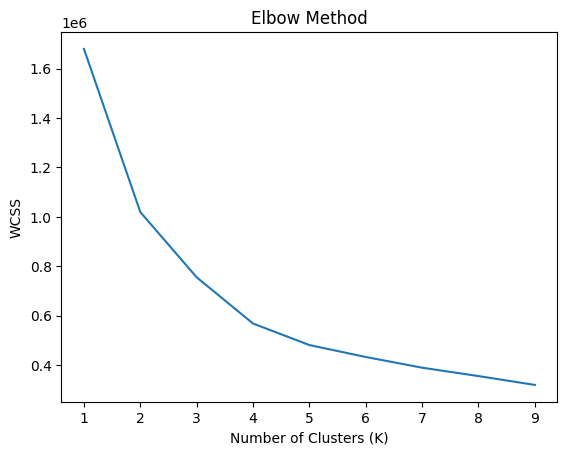

In [10]:
plt.plot(range(1, 10), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

In [11]:
scaler = StandardScaler()

In [12]:
# Fit the scaler on the features data and transform it
scaled_features = scaler.fit_transform(features_data)

In [13]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=42)

In [14]:
# Assign the cluster labels to the original data
features_data['Cluster'] = kmeans.labels_

In [15]:
# Rescale the features back to the original scale
features_data_scaled_back = scaler.inverse_transform(scaled_features)
df_rescaled = pd.DataFrame(features_data_scaled_back, columns=features_data.columns[:-1])  # Exclude the cluster labels

In [16]:
# Add the cluster labels to the rescaled DataFrame
df_rescaled['Cluster'] = features_data['Cluster'].values  # Ensure indices match between df_filtered and df_rescaled

In [17]:
df_rescaled.head()

,AgeCategory,AdjustedHealthRatio,LifestyleScore,BMI,Cluster
0,12.0,0.36,2.300000,28.87,0
1,9.0,0.90,0.600000,34.30,2
2,12.0,0.90,3.071429,32.98,0
3,13.0,13.50,2.000000,25.06,1
4,12.0,2.70,3.500000,30.23,0


In [18]:
df_rescaled.groupby('Cluster').mean()

,AgeCategory,AdjustedHealthRatio,LifestyleScore,BMI
Cluster,,,,
0,11.616554,1.427626,2.611612,26.927660
1,11.215044,13.788102,2.543163,28.850389
2,8.693759,1.450817,1.388176,27.506586
3,8.958695,1.551019,2.364710,39.271097


# Plots

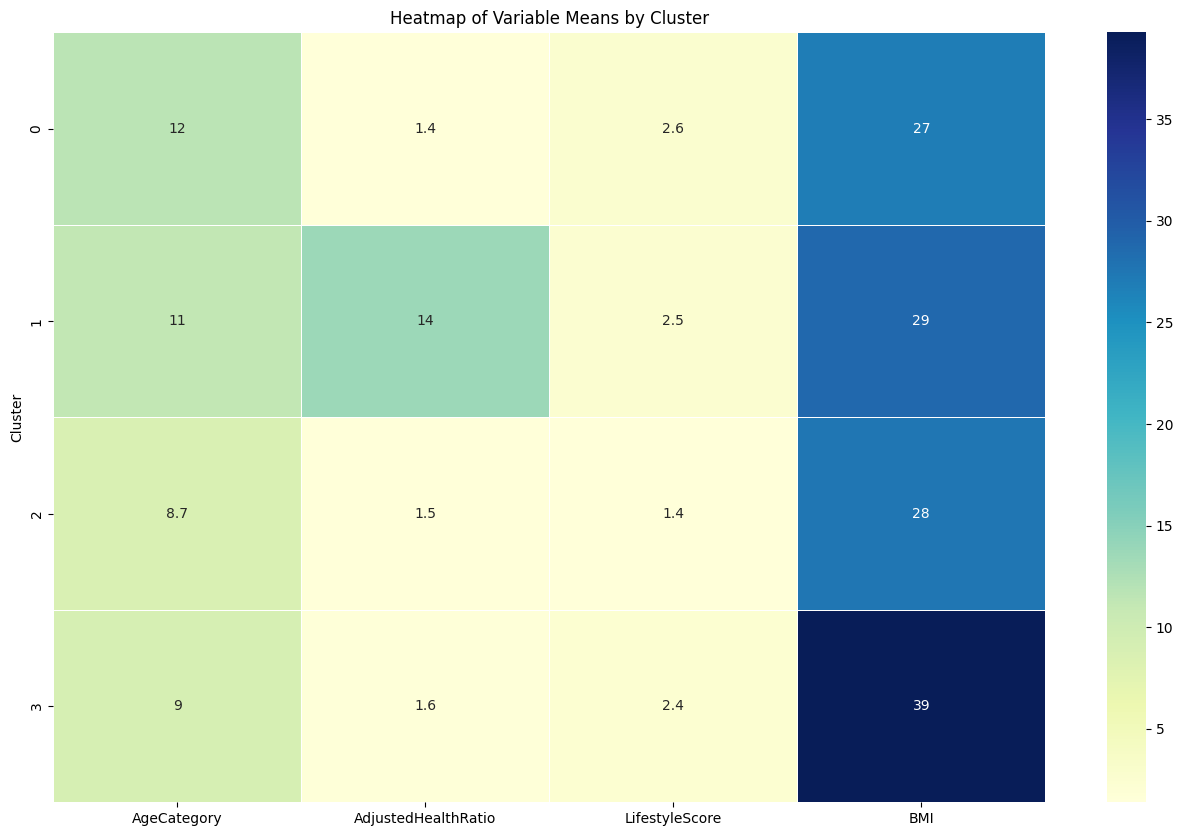

In [19]:
# Group the data by cluster and calculate the mean value for each variable within each cluster
cluster_means = df_rescaled.groupby('Cluster').mean().reset_index()

# Set 'Cluster' as the index so it doesn't appear as a variable
cluster_means.set_index('Cluster', inplace=True)

# Create a heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Variable Means by Cluster')
plt.show()

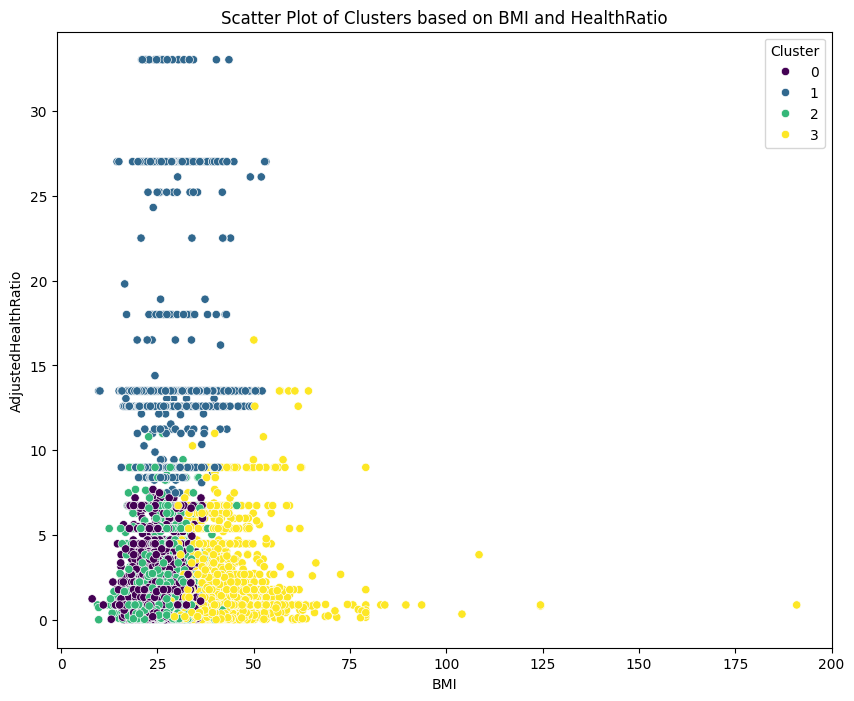

In [20]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_rescaled, x='BMI', y='AdjustedHealthRatio', hue='Cluster', palette='viridis')
plt.title('Scatter Plot of Clusters based on BMI and HealthRatio')
plt.xlabel('BMI')
plt.ylabel('AdjustedHealthRatio')
plt.legend(title='Cluster')
plt.show()

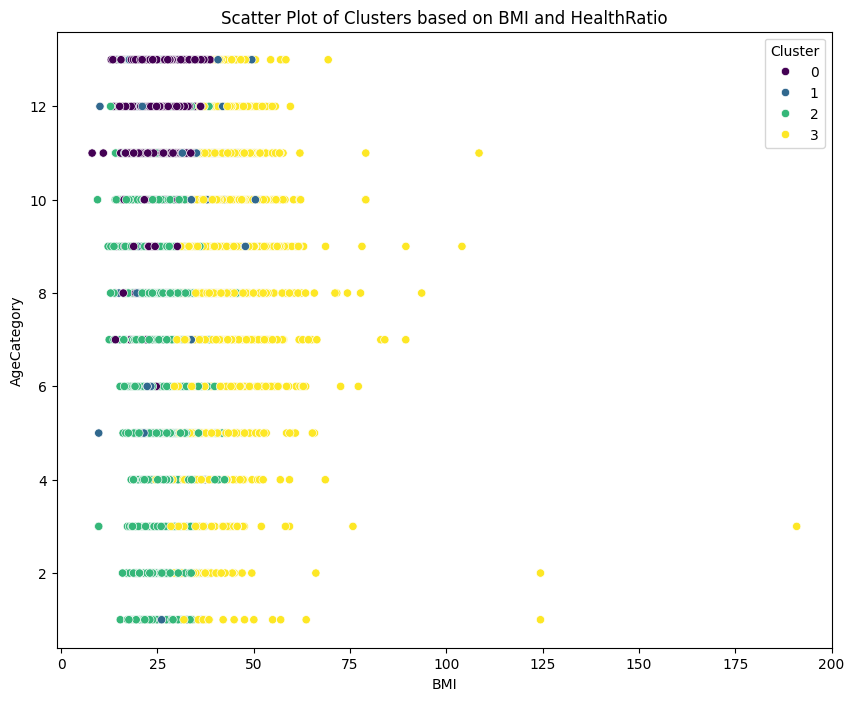

In [23]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_rescaled, x='BMI', y='AgeCategory', hue='Cluster', palette='viridis')
plt.title('Scatter Plot of Clusters based on BMI and HealthRatio')
plt.xlabel('BMI')
plt.ylabel('AgeCategory')
plt.legend(title='Cluster')
plt.show()

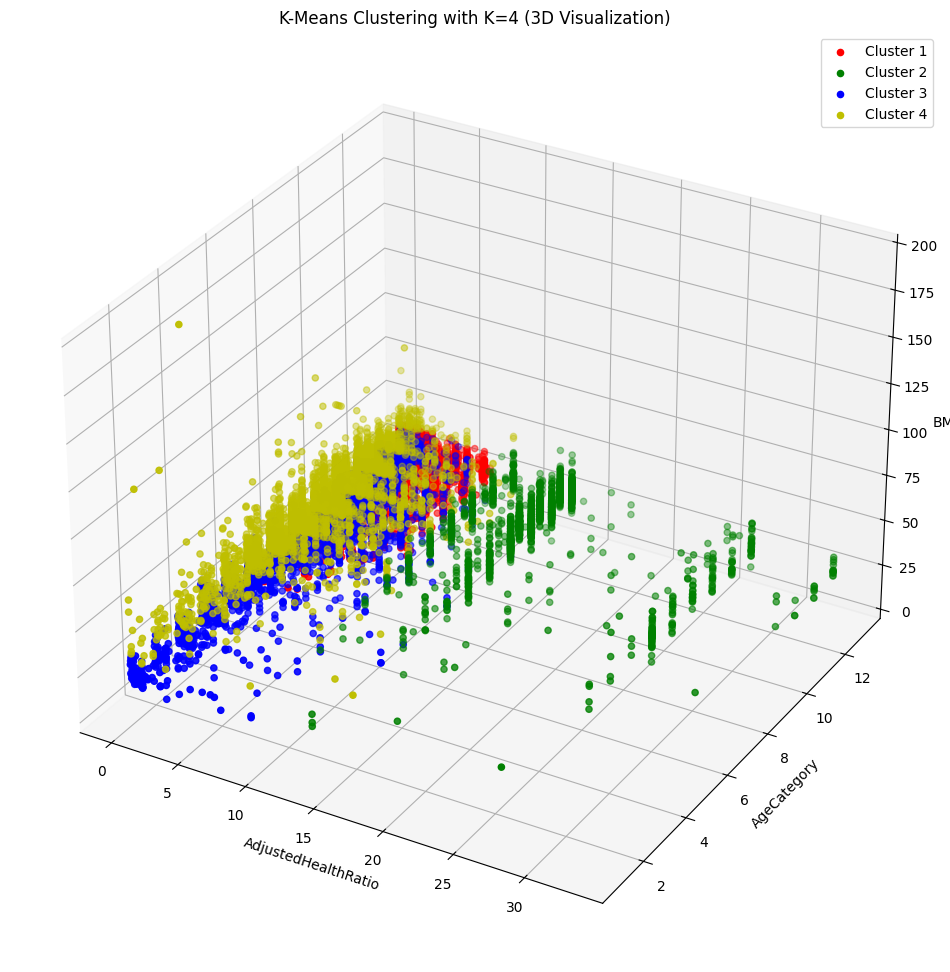

In [24]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each cluster
colors = ['r', 'g', 'b', 'y']

# Plot data points in 3D space
for cluster in range(4):
    cluster_data = df_rescaled[df_rescaled['Cluster'] == cluster]
    ax.scatter(cluster_data['AdjustedHealthRatio'], cluster_data['AgeCategory'], cluster_data['BMI'],
               c=colors[cluster], label=f'Cluster {cluster + 1}')

ax.set_xlabel('AdjustedHealthRatio')
ax.set_ylabel('AgeCategory')
ax.set_zlabel('BMI')
ax.set_title(f'K-Means Clustering with K=4 (3D Visualization)')

plt.legend()
plt.show()

In [25]:
# Create a 3D scatter plot
fig = px.scatter_3d(df_rescaled, x='AdjustedHealthRatio', y='AgeCategory', z='BMI', color='Cluster')

# Customize the plot
fig.update_layout(
    scene=dict(xaxis_title='AdjustedHealthRatio', yaxis_title='AgeCategory', zaxis_title='BMI'),
    scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),  # Adjust the initial camera view
    height=800,  # Set the height of the plot
    width=1000   # Set the width of the plot
)
fig.update_traces(marker=dict(size=5))

# Show the 3D plot
fig.show()

The clustering has resulted in groups that show differences in key health-related metrics. Cluster 0, for example, shows the highest average 'BMI', which may indicate a group with higher obesity risk. Conversely, Cluster 2 has a lower 'BMI' mean, perhaps indicating a healthier weight status. The 'LifestyleScore' means vary across clusters, potentially reflecting different lifestyle choices that may affect health. The 'AgeCategory' means do not show significant differences across clusters, which suggests that age was not a primary driver of cluster separation in this analysis.

Goodness of Clustering:
To determine the goodness of the clustering, you might consider the following:

Silhouette Score: Calculate the silhouette score for the chosen number of clusters to quantify how well each object lies within its cluster. A higher silhouette score indicates better-defined clusters.
Cluster Validation: If possible, validate the clusters with external data or qualitative analysis to see if they make sense within the context of your domain.